# Introduction

Disclaimer:
This Notebook is inspired by the great notebook by Evan Juras.
You can find the original jupyter book here: (https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models)

This notebook shows you how to train your own YOLOv8 Object detection model and export it for the IMX500 Sensor (e.g. for the Raspberry Pi AI Camera).


### How to use Colab
Colab is a tool by Google, that allows you to use High End GPUs and TPUs to train and convert AI models fast. It creates a virtual machine in your browser complete with a Linux OS, filesystem and Python environment. You can click the play buttons to excecute code.






**Connect to VM**

Connect to the Virtual machine in the top right corner. Change the Type from CPU to GPU (e.g. T4)

#Before you start

This tutorial is based on images labeled with Label-Studio.
If you use a different labeling software, ensure your labeled data is in the following structure:

An "images" folder containing the images
A "labels" folder containing the labels in YOLO annotation format
A classes.txt labelmap file that contains all the classes
A notes.json file that contains info specific to Label Studio (this file can be ignored)

# Upload your images

Zip your labled images and name the file data (data.zip is the final name)
The data.zip folder should have the following structure and names:
data.zip
- images
- labels
- classes.txt
- (notes.json)

Upload you zipped labeled images into the file directionary

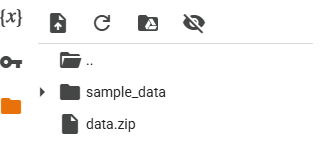


In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

For training, you need the images(and label files) sorted into two folders: Training and Validation. Use the code below to automaticaly and randomly split your dataset. You can choose the percentage for the split with the "--train_pct" parameter

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-05-22 19:04:48--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-05-22 19:04:48 (53.6 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 659
Number of annotation files: 659
Images moving to train: 593
Images moving to validation: 66


# 3.&nbsp;Install Ultralytics

For training and exporting we use the Ultralytics toolkit. Install it with the command below

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# 4.&nbsp;Configure Training


Now you only have to create a .yaml file, that stores all the different classes and paths to the validation and training files.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 4
names:
- Alive
- AliveZone
- Dead
- DeadZone


# 5.&nbsp;Train Model

## 5.1 Training Parameters
After all the data is organized, were ready for training.
Altough you could train yolov5 and yolo11 models, only yolov8 models are tested and recommended by us! There are different model sizes (n, s, m, x and xl). The IMX500 Sensor only supports **n**ano models.

###Parameters:
**Number of epochs (`epochs`)**
The number of epochs is how often the training goes over the dataset. For smaller models(<200 Images) use 60 epochs. Otherwise, use 40 epochs.


**Resolution (`imgsz`)**

You can use the 640x640 resolution, it's what works best with the IMX500 Sensor and YOLOv8 Models. For faster models, you can use the 320x320 resolution


## 5.2 Run Training

Run the following code block to begin training. If you want to use a different number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov8n.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 21.5M/21.5M [00:00<00:00, 296MB/s]
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, i

The Training might take some time, so don't quit it early, as it optimizes the model in the end

#6.&nbsp;Test Model

After successful training, you can test the model. It's stored under runs/detect/train/weights/best.pt

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

image 1/66 /content/data/validation/images/04b74c2f-train397.jpg: 256x320 (no detections), 75.0ms
image 2/66 /content/data/validation/images/072bef1a-train5.jpg: 256x320 (no detections), 8.6ms
image 3/66 /content/data/validation/images/08ff4ae8-train253.jpg: 256x320 1 Dead, 1 DeadZone, 8.3ms
image 4/66 /content/data/validation/images/0ac1af36-train200.jpg: 256x320 1 Alive, 1 AliveZone, 11.8ms
image 5/66 /content/data/validation/images/127b28fe-train369.jpg: 256x320 1 Alive, 1 AliveZone, 16.0ms
image 6/66 /content/data/validation/images/155d2d80-train72.jpg: 256x320 1 Alive, 10.3ms
image 7/66 /content/data/validation/images/16124546-train417.jpg: 256x320 1 DeadZone, 12.0ms
image 8/66 /content/data/validation/images/16957ba8-train472.jpg: 256x320 1 Alive, 1 DeadZone, 10.7ms
image 9/66 /content/data/validation/images/18c08026

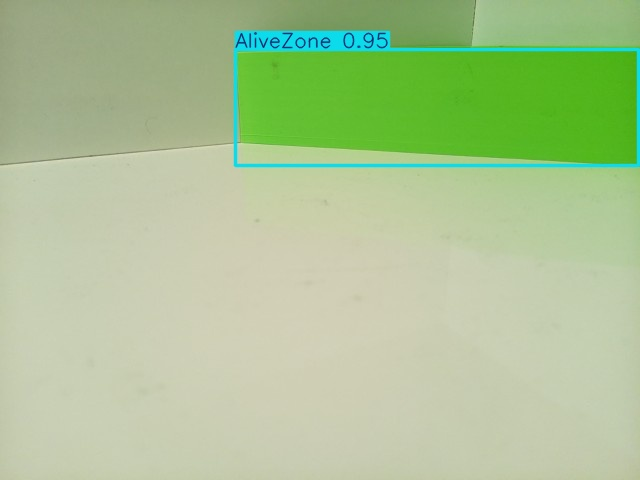

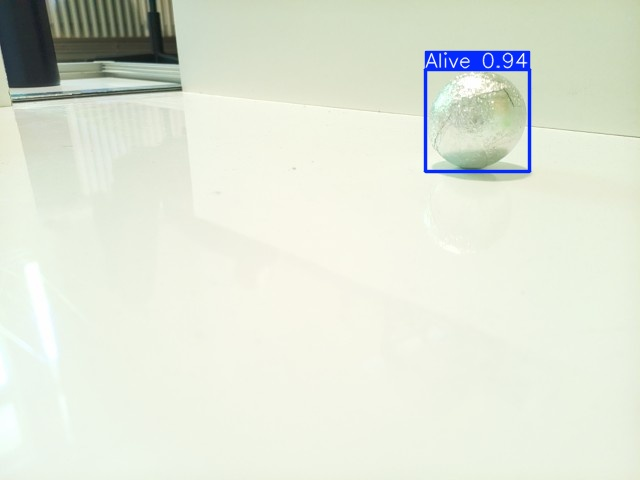

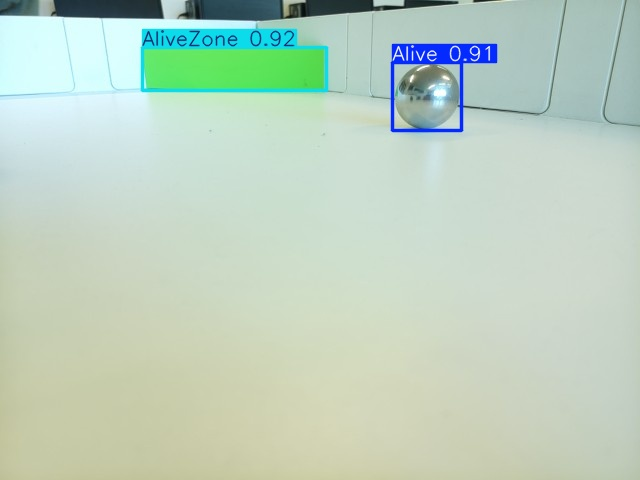

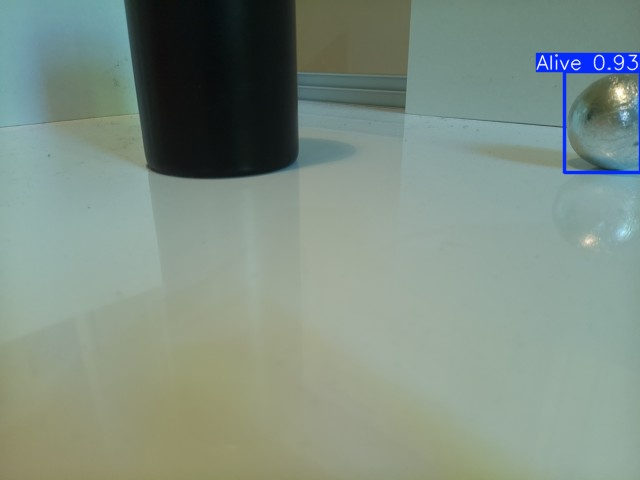

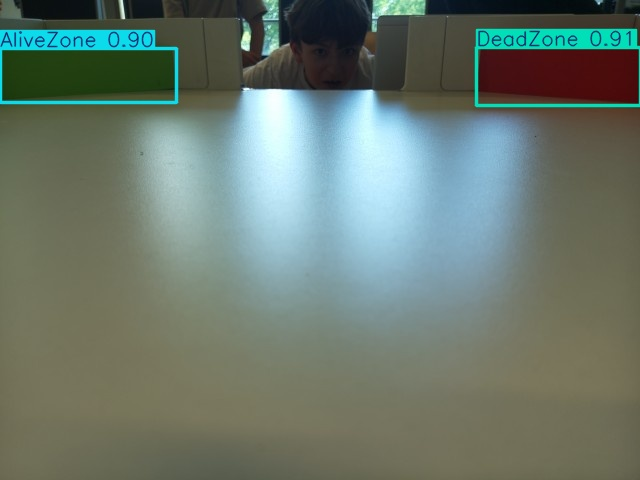

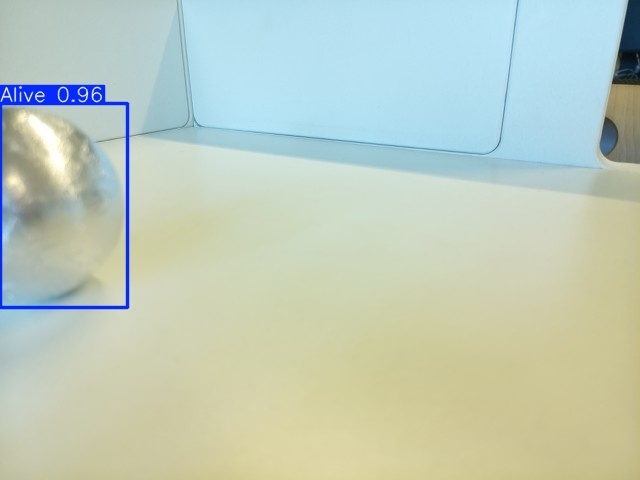

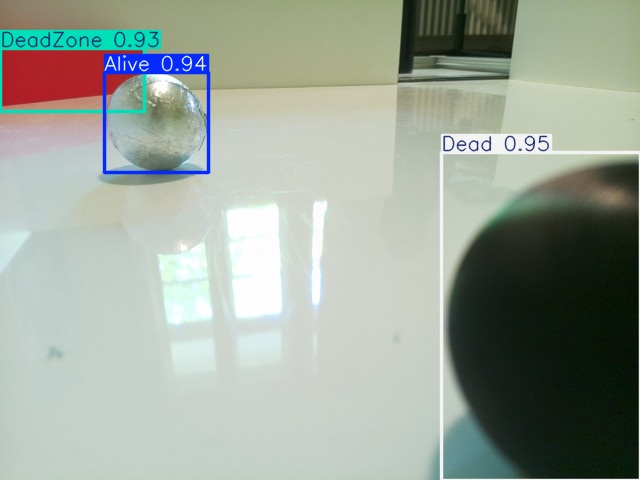

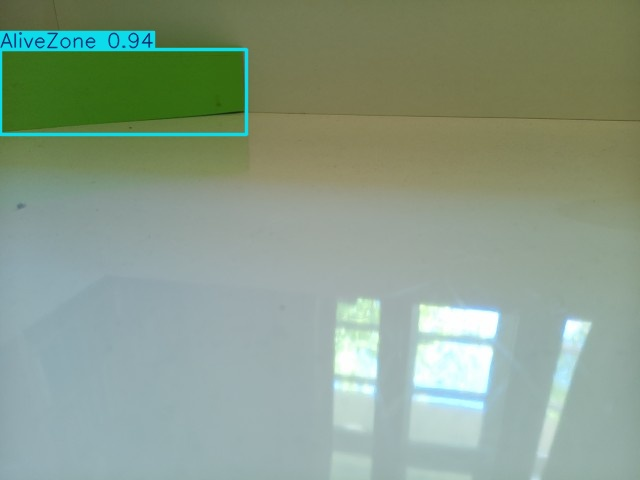

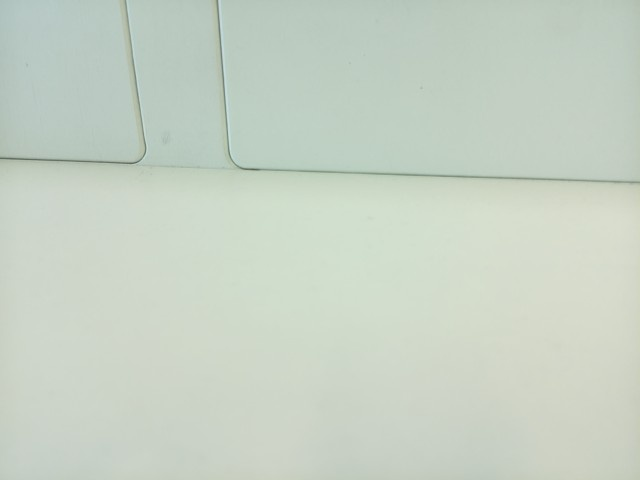

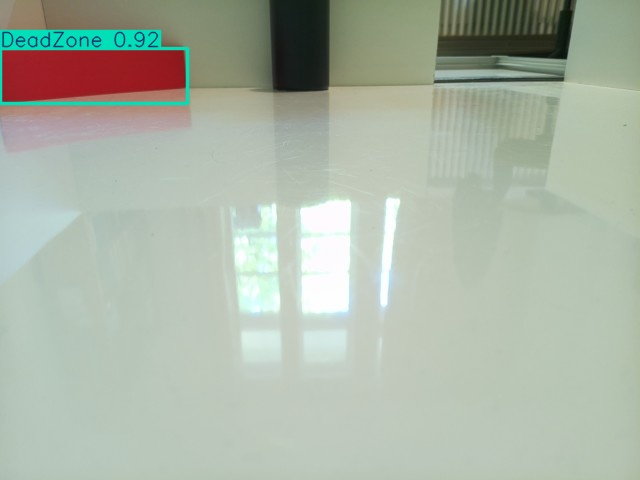

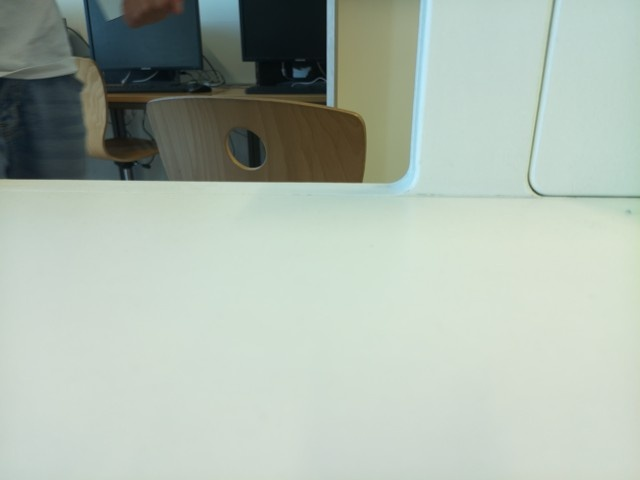

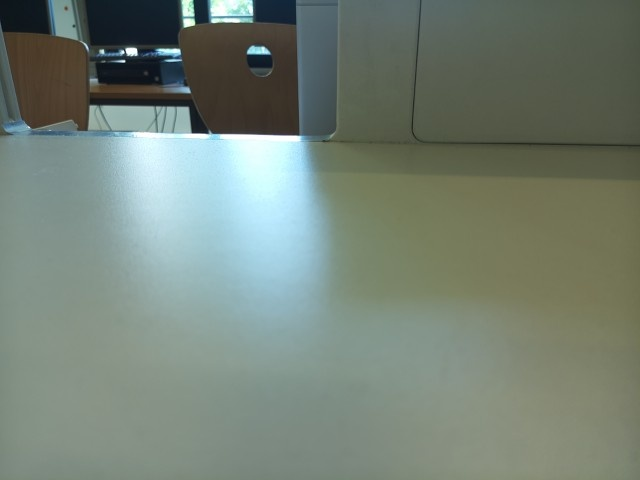

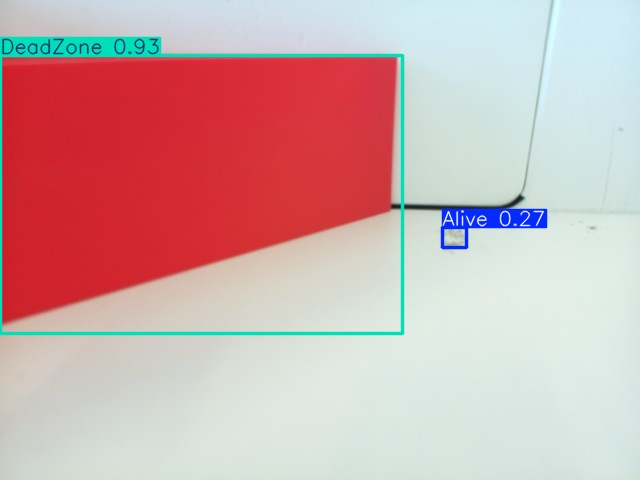

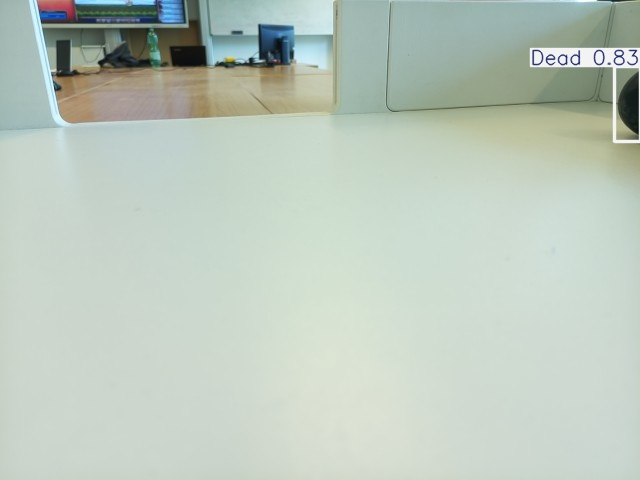

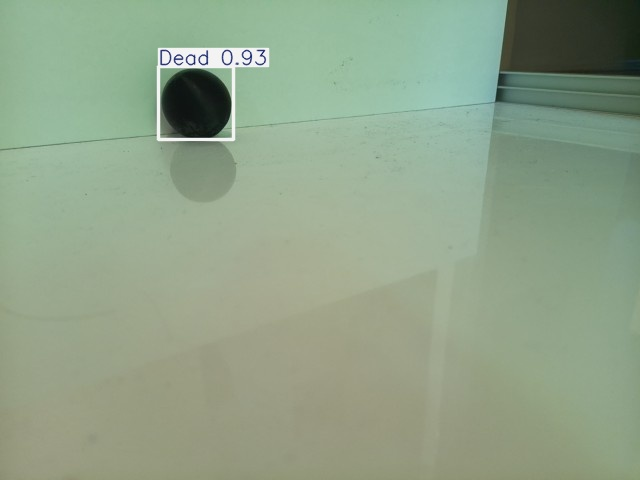

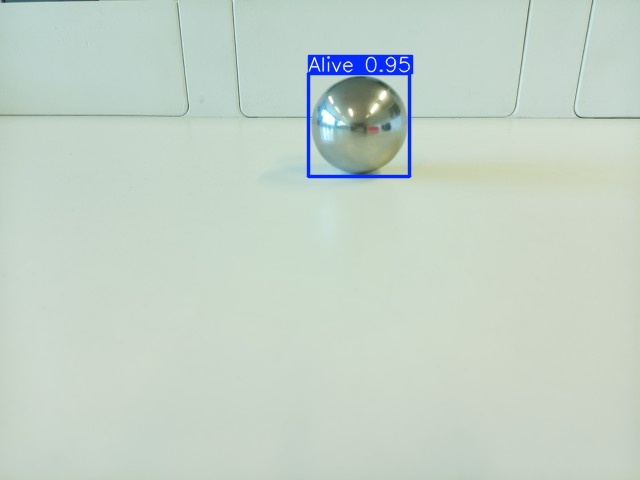

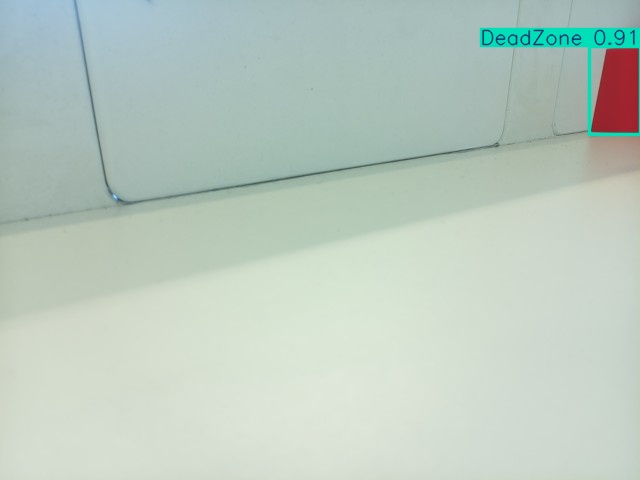

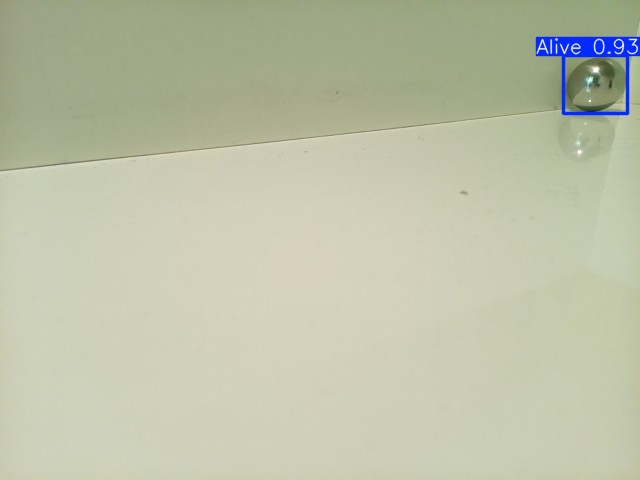

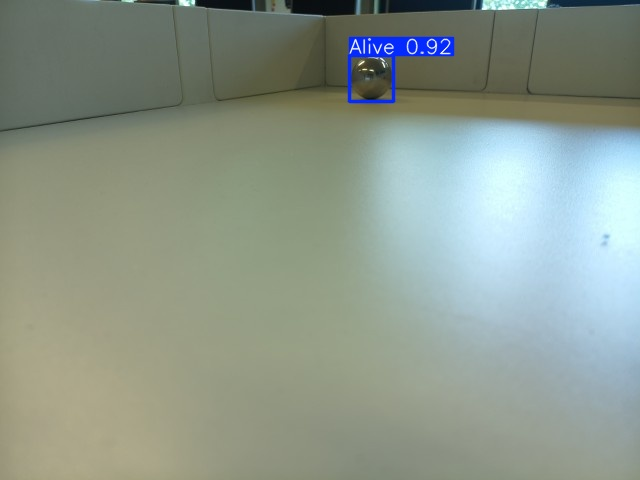

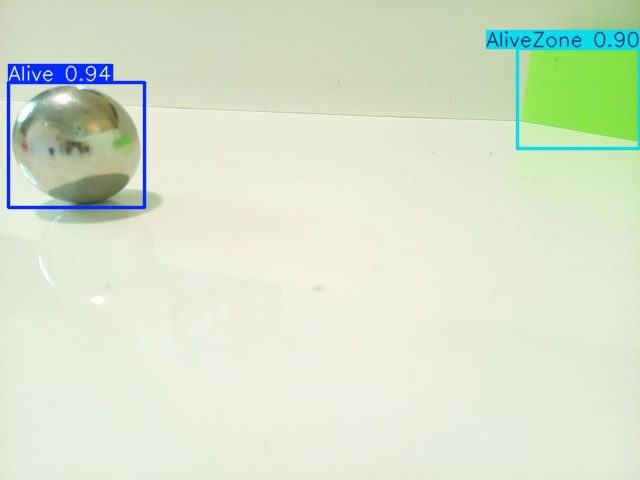

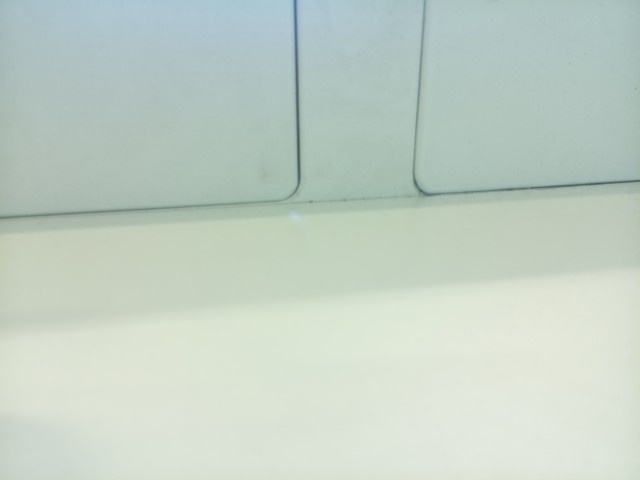

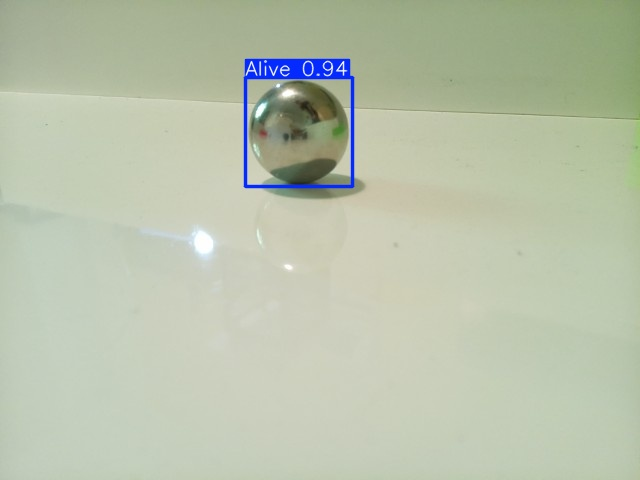

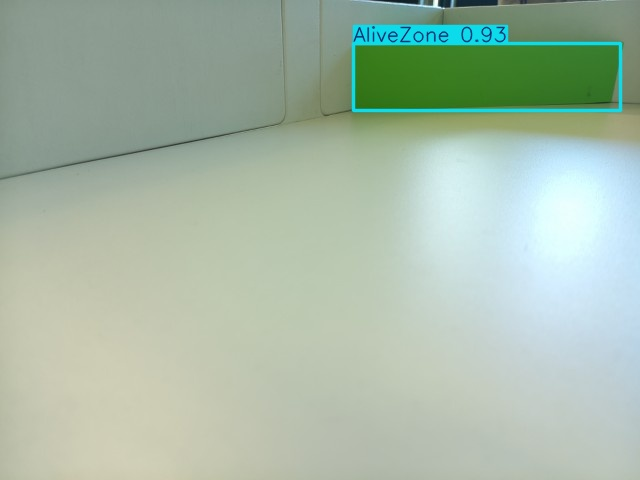

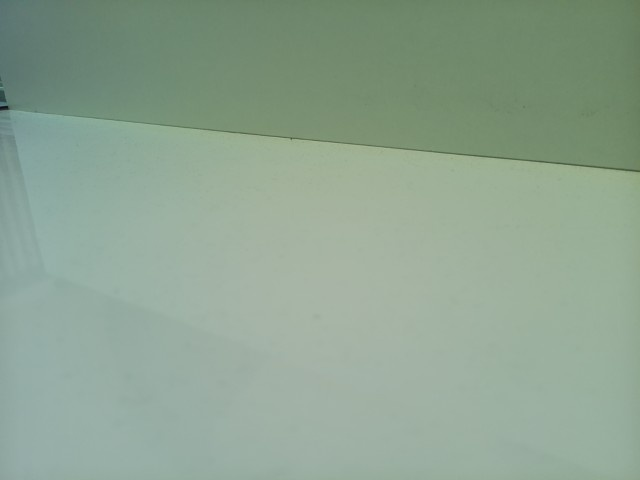

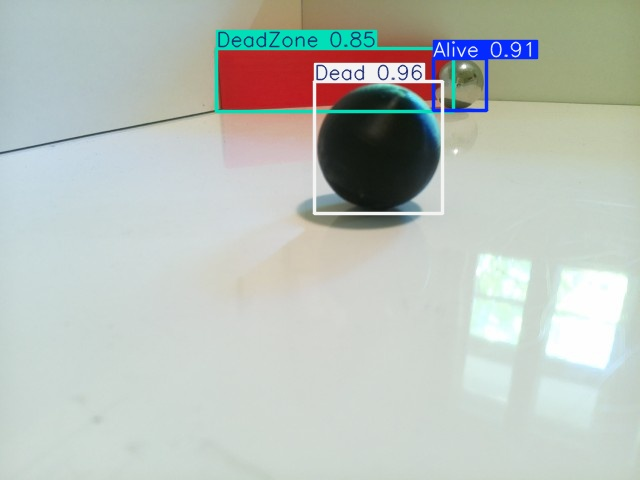

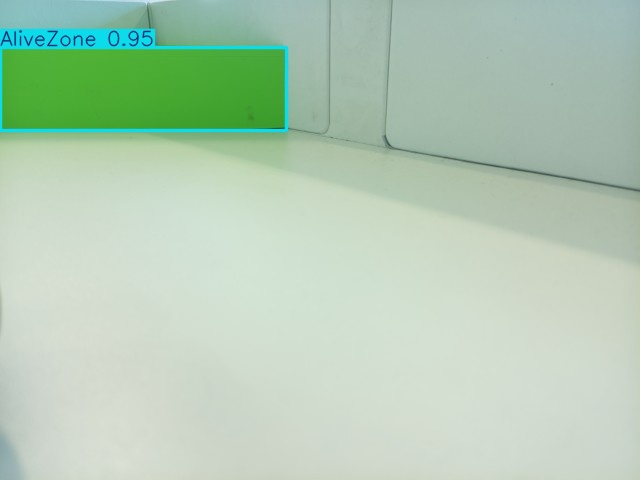

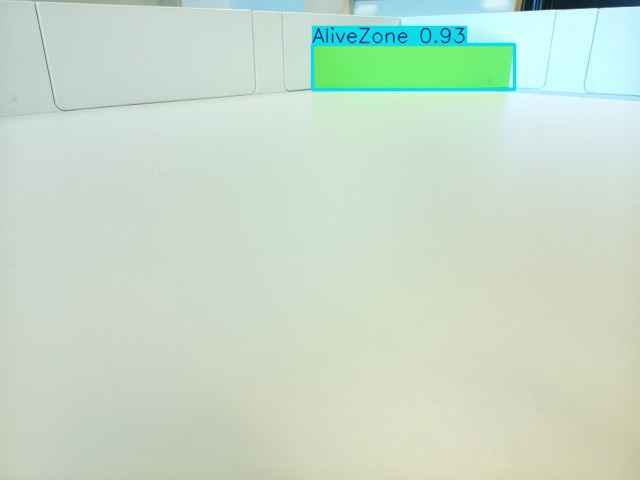

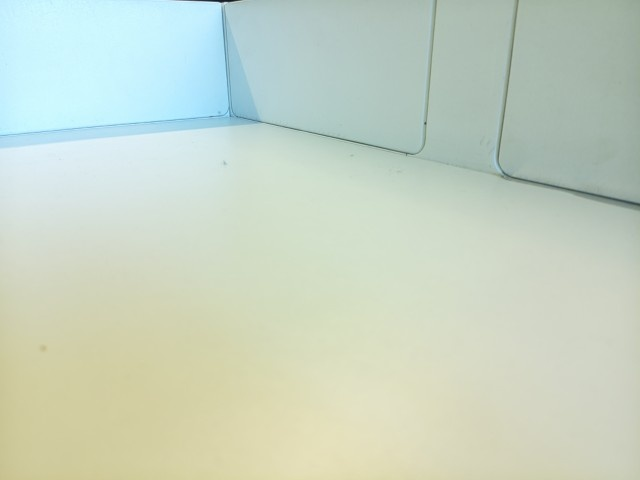

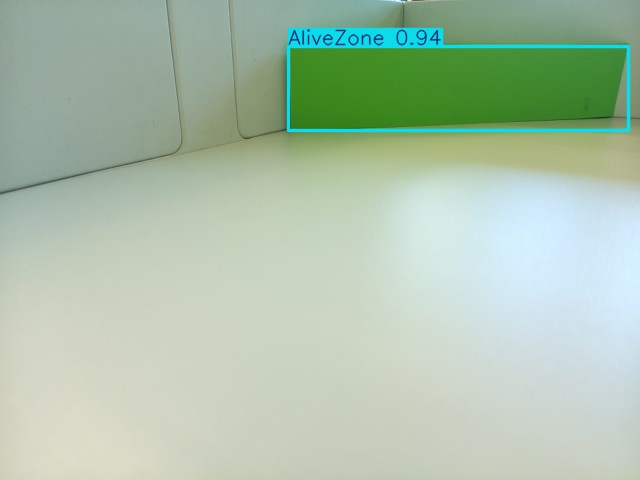

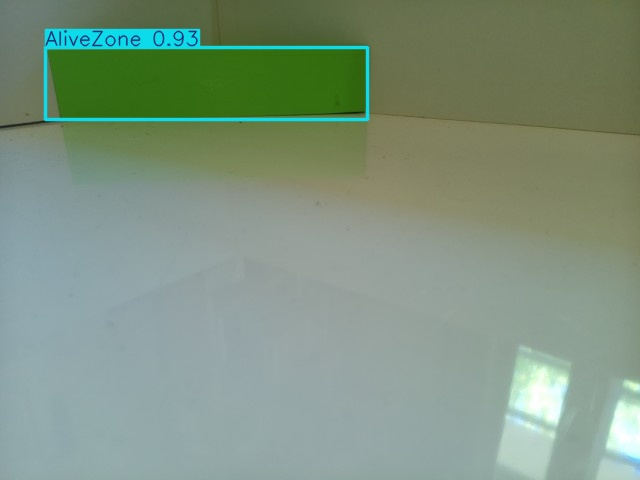

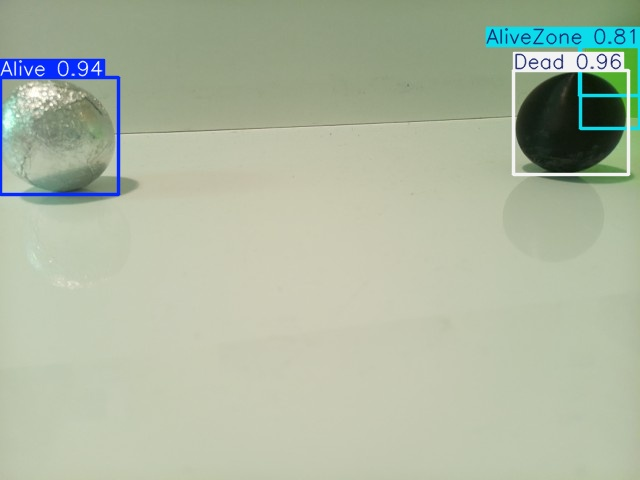

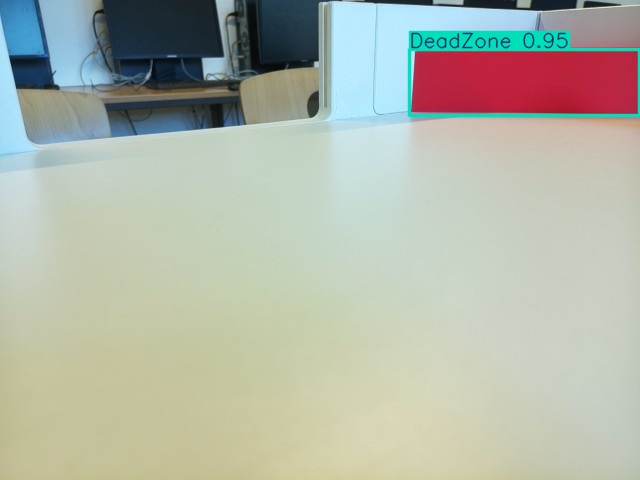

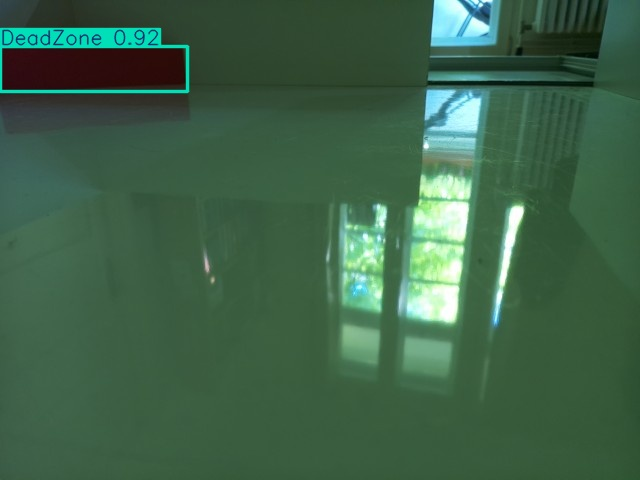

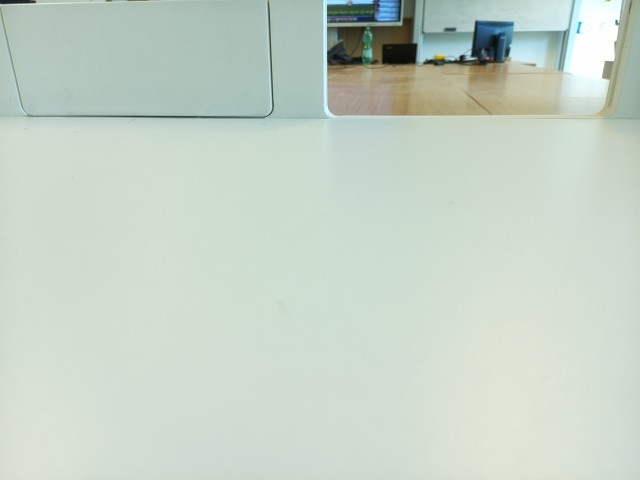

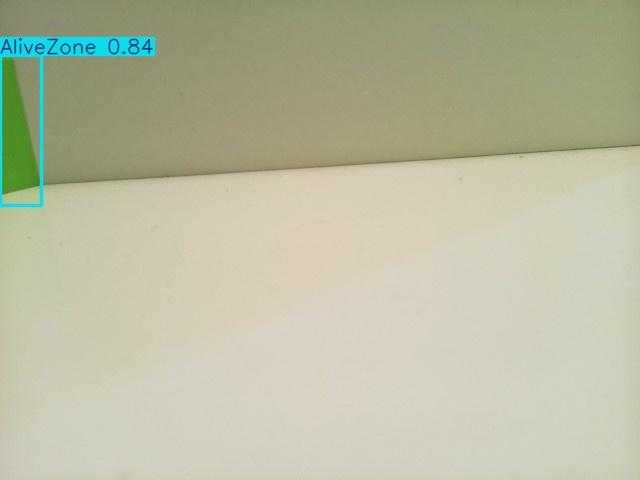

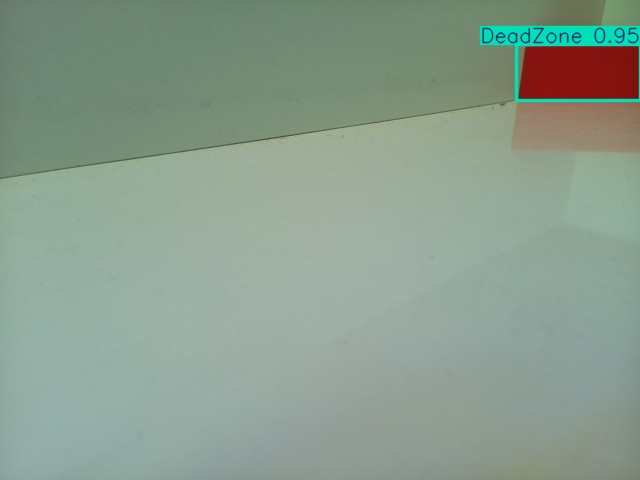

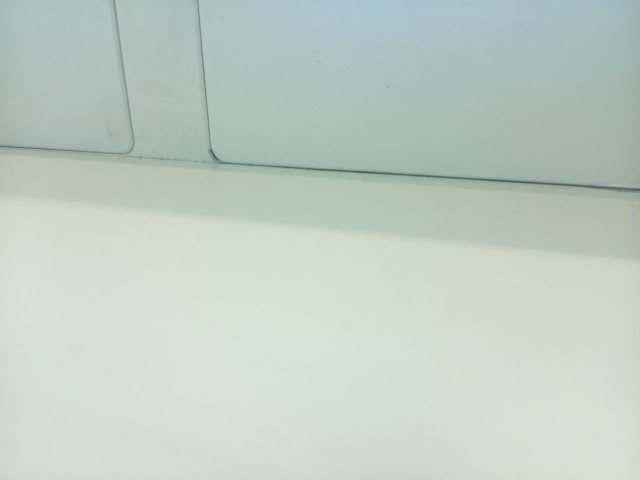

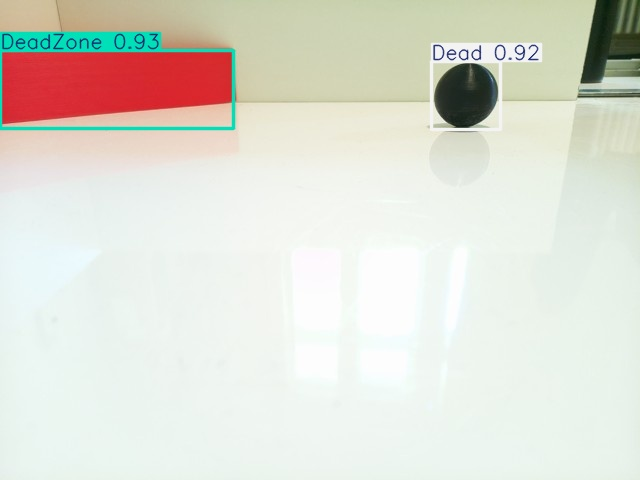

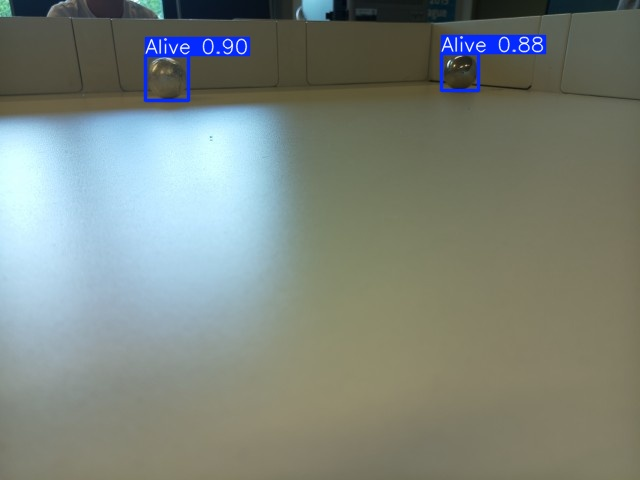

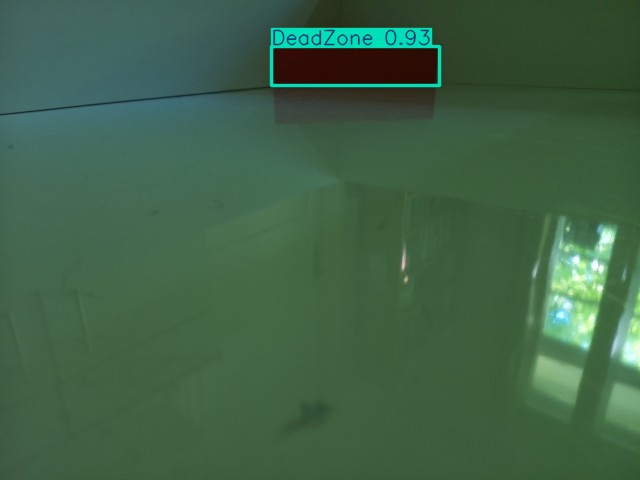

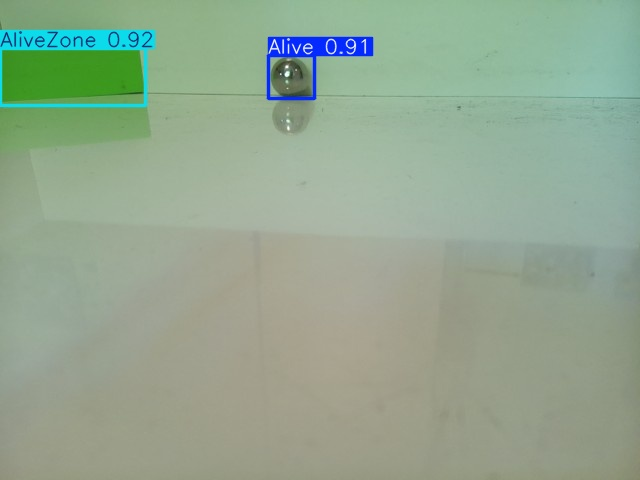

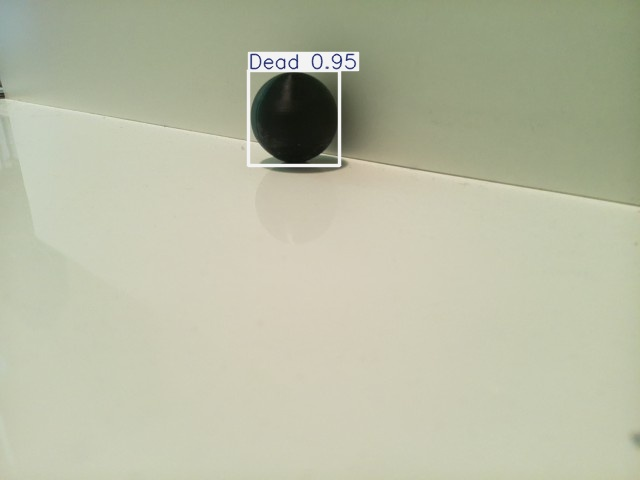

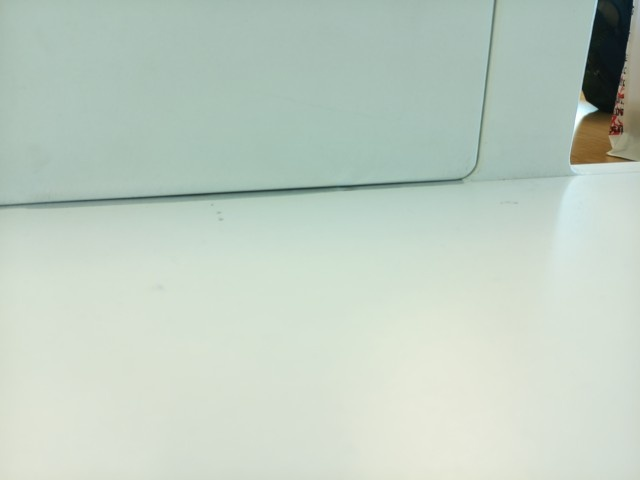

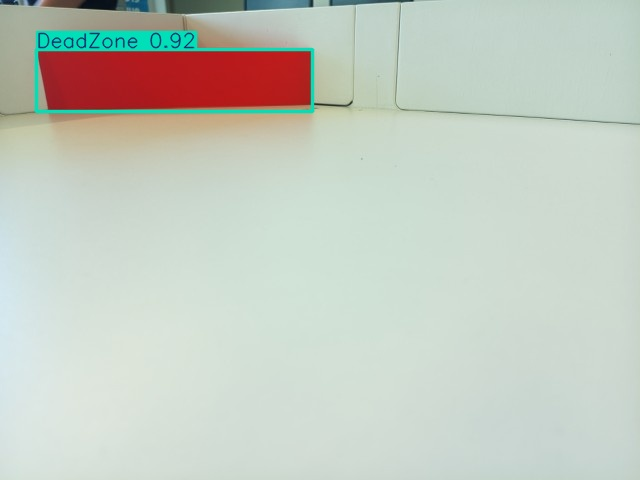

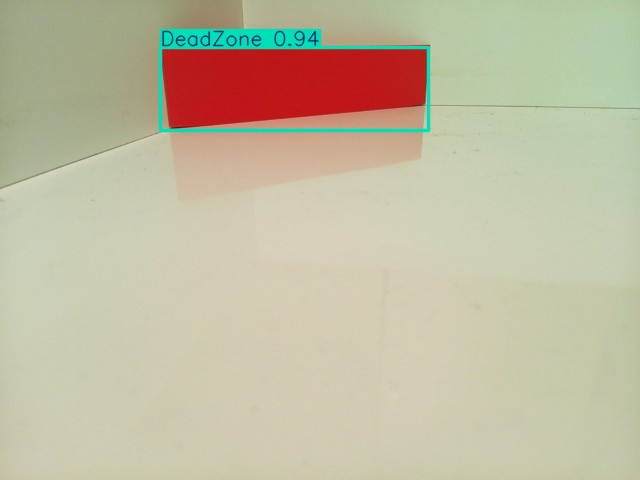

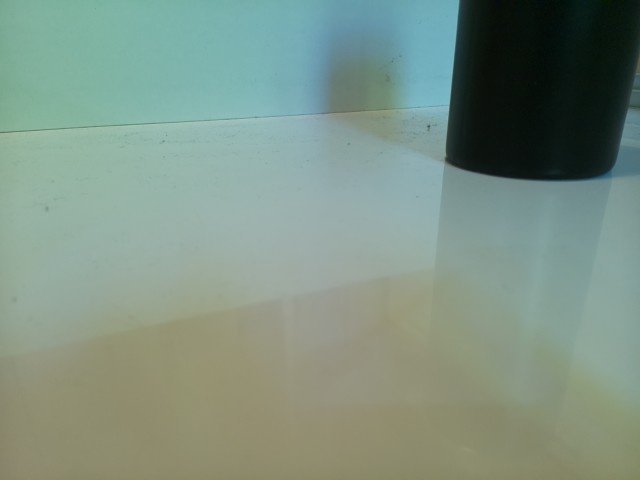

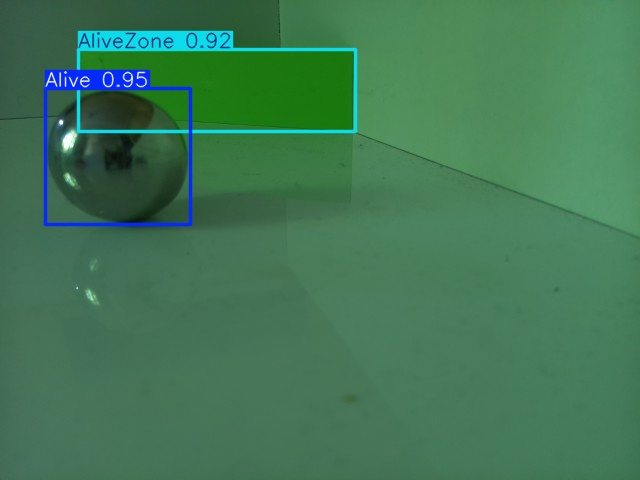

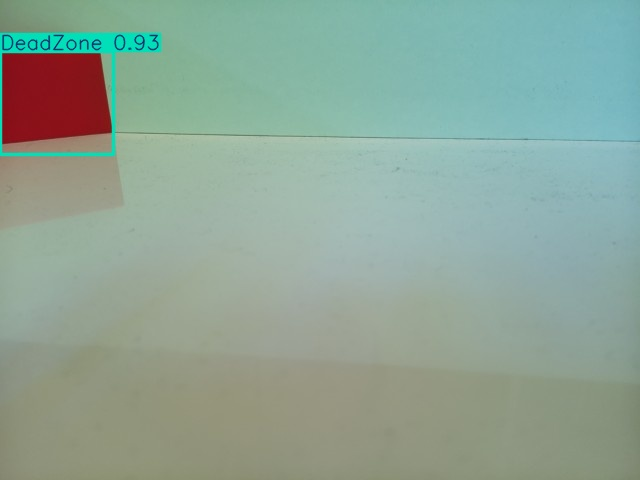

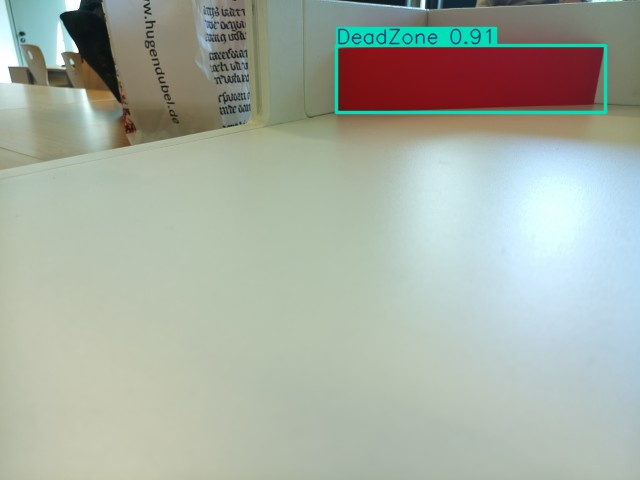

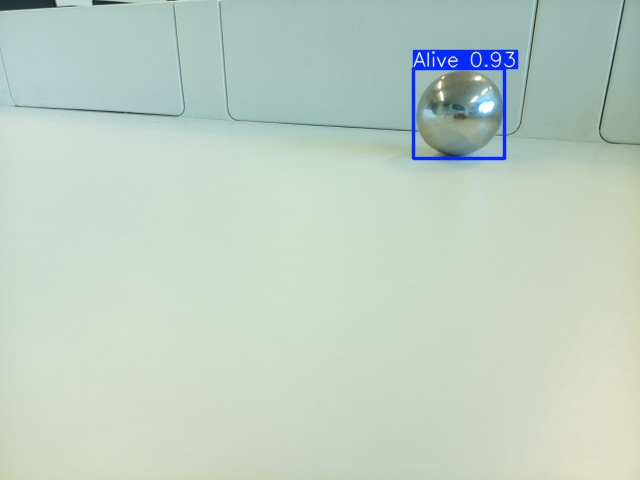

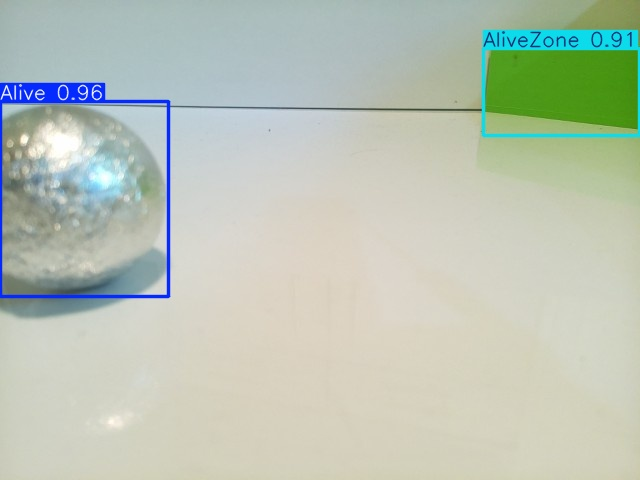

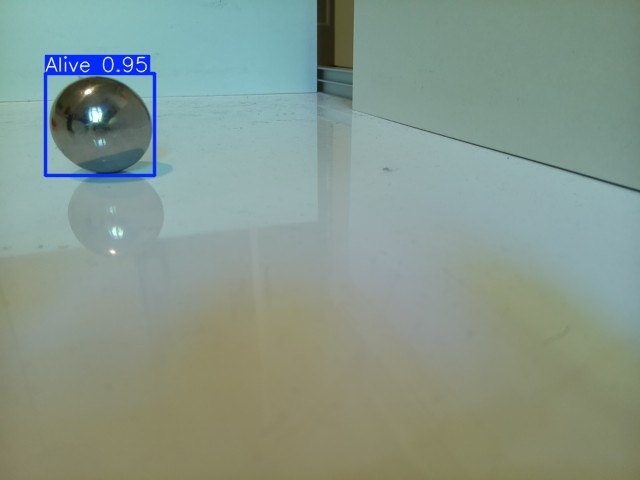

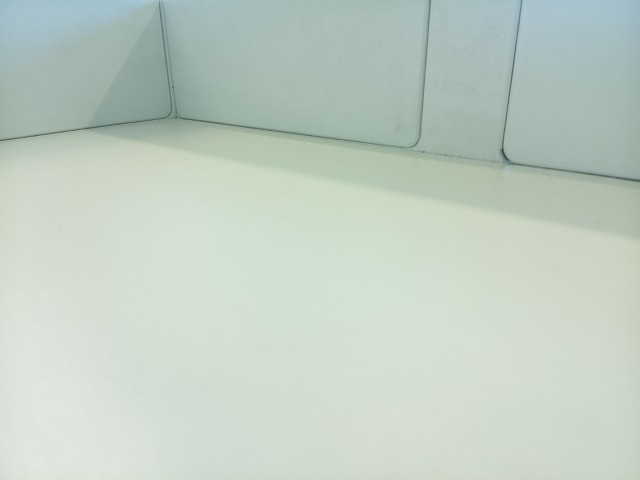

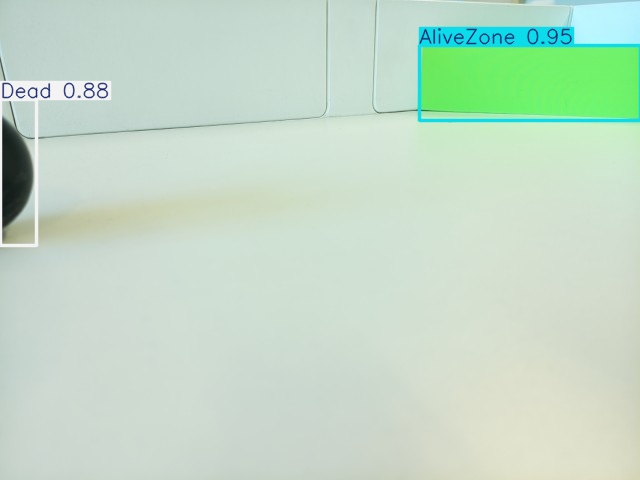

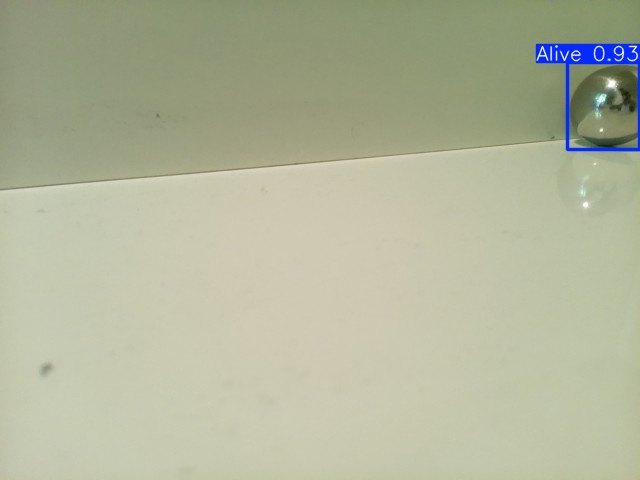

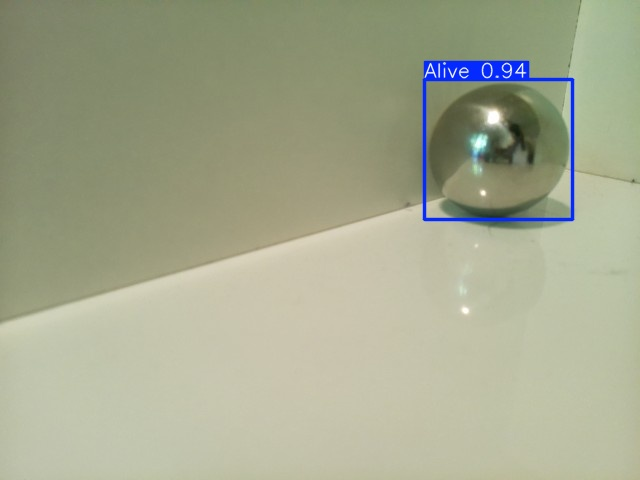

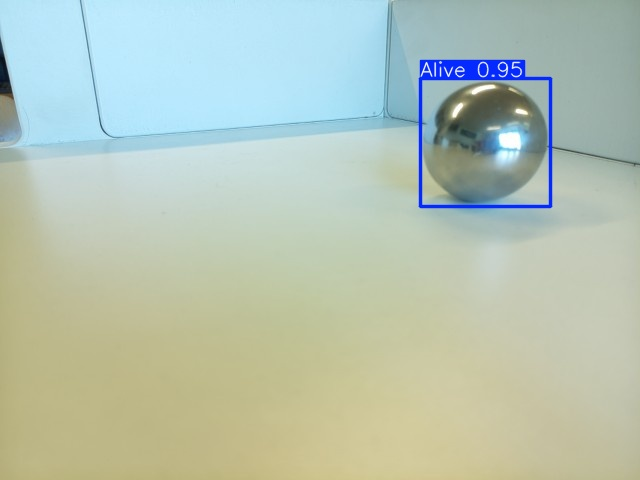

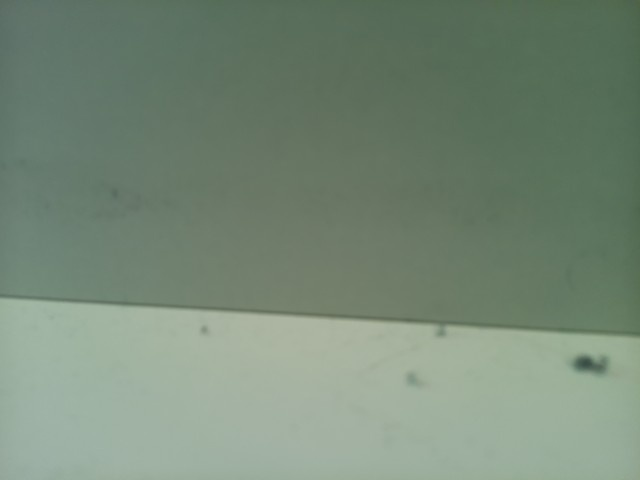

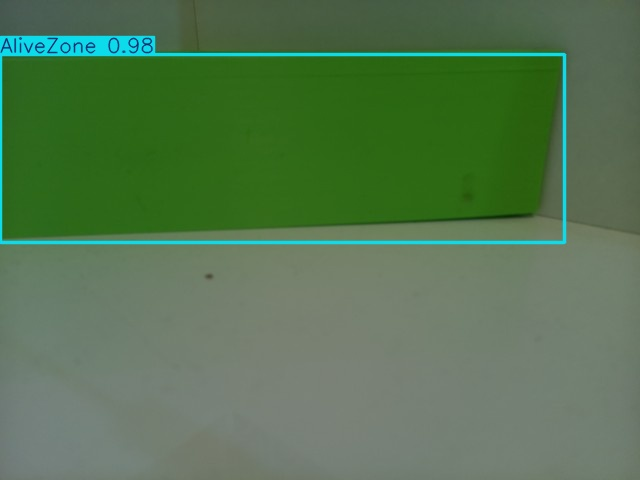

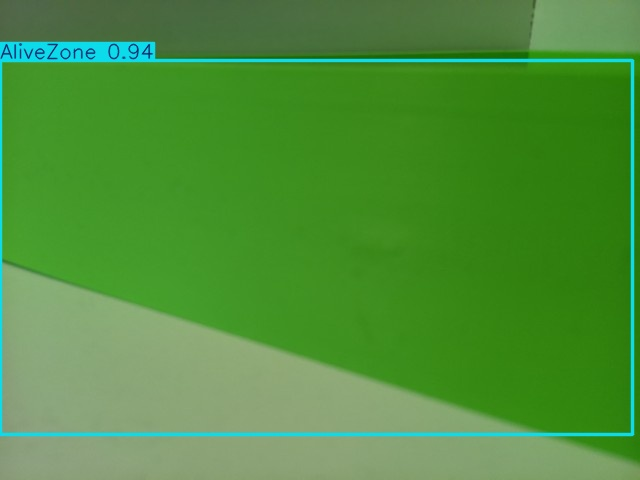

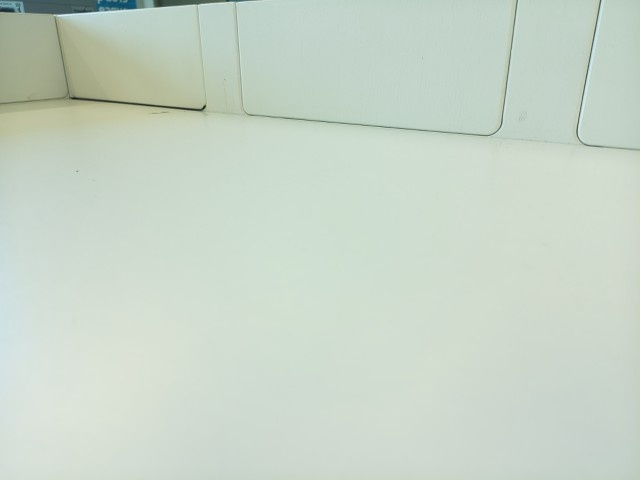

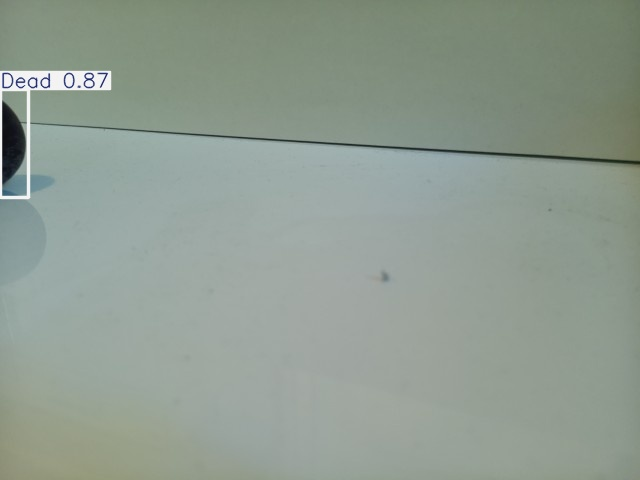

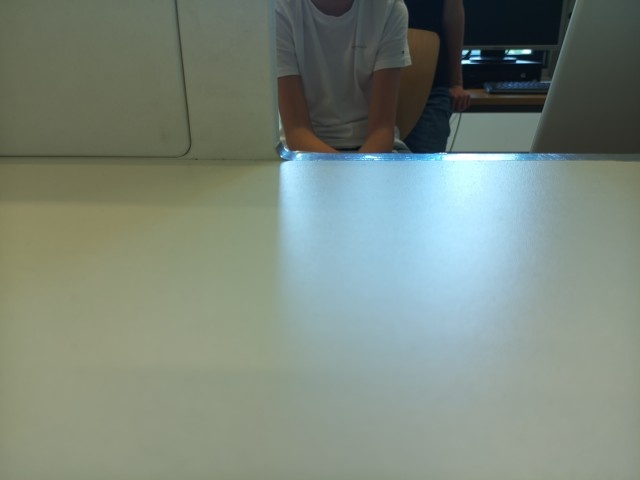

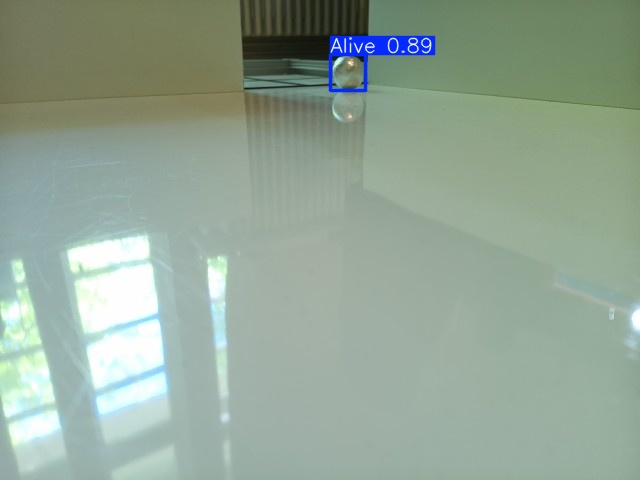

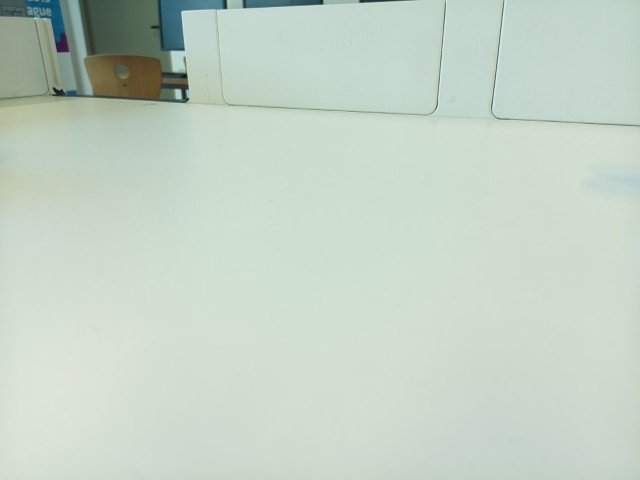

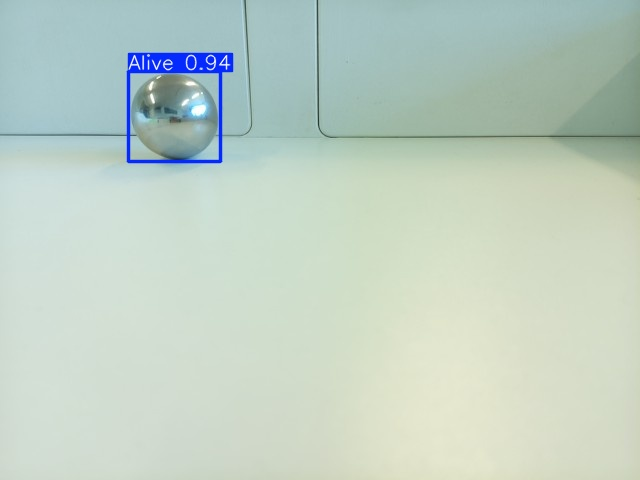

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:66]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model now should draw boxes with confidence values around the objects. If the model isn't working as expected, make sure you labeled everything correctly and took good photos. You can also increase picture amount and epochs

#7.&nbsp;Deploy Model

If you're satisfied with the results, it's time for exporting it to the IMX500 Sensor. You have to install the MCT(Model compression Toolkit) by Sony. Also, install all other plugins below

In [ ]:
!pip install model_compression_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.7/962.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 114.2 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.4
    Uninstalling pydantic-2.11.4:
      Successfully uninstalled pydantic-2.11.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existin

In [ ]:
!pip install edge-mdt-tpc

In [ ]:
!pip install sony-custom-layers

In [ ]:
!pip install imx500-converter[pt]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3567 sha256=7a60a2dfc8bfc59bd9d35c248b652aafb080b6098c952081b06cf98e14f1770e
  Stored in 

Now that everything is installed correctly, you can run the PTQ(Post Training Quantization) and export for the IMX500 sensor(This will take some time)

In [ ]:
!wget -O /content/converter.py https://raw.githubusercontent.com/Fazeli24/YOLOv8/refs/heads/main/converter.py

!python converter.py

--2025-05-22 19:38:21--  https://raw.githubusercontent.com/Fazeli24/YOLOv8/refs/heads/main/converter.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘/content/converter.py’

/content/converter. 100%[===================>]     220  --.-KB/s    in 0s      

2025-05-22 19:38:21 (2.98 MB/s) - ‘/content/converter.py’ saved [220/220]

WARNING ⚠️ Exporting on CPU while CUDA is available, setting device=0 for faster export on GPU.
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
WARNING ⚠️ IMX export requires int8=True, setting int8=True.
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 lay

Move the resulting .zip file to your main directory:

In [ ]:
!mv runs/detect/train/weights/best_imx_model/packerOut.zip packerOut.zip

You can now download the packagerOut.zip file from the left file bar

#Deployment
Now you have a quantized model ready for deployment on your Sony AI Camera! For this last step, you need your Raspberry Pi (3-5). Move your packerOut.zip file to a directory of the pi.
Start by installing the imx500 toolkit using the terminal:


---



####sudo apt install imx500-all imx500-tools




then, convert the packerOut.zip file to a network.rpk file:



####imx500-package -i path/to/packerOut.zip -o path/to/output/folder


---



Replace "path/to/packerOut.zip" with you path to the packerOut.zip file and "path/to/output/folder" to your chosen output folder.

You now have a completly converted and quantized model file to run on your IMX500 Sensor.